# Предсказание загрузки такси в аэропортах 

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

В качестве целевой метрики будем использовать RMSE. Значение метрики на тестовой выборке должно быть не больше 48.

**План выполнения проекта**
1) Загрузить данные и выполнить их ресемплирование по одному часу.
2) Проанализировать данные.
3) Обучить разные модели с различными гиперпараметрами. Сделайть тестовую выборку размером 10% от исходных данных.
4) Проверить данные на тестовой выборке и сделать выводы.

## Загрузка и изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GridSearchCV,
    cross_val_score
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

Исследуем данные. Количество заказов находится в столбце 'num_orders'.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Данные представляют собой временной ряд с переменной "количество заказов". Интервалы между записями составляют 10 минут.

Преобразуем индекс в значения времени и отсортируем по возрастанию.

In [5]:
# проверим, есть ли в данных пропуски
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Преобразуем значения datetime в соответствующий формат.

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [8]:
print('Данные расположены в хронологическом порядке', df.index.is_monotonic_increasing)

Данные расположены в хронологическом порядке True


Сортировка не требуется.

In [9]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


Данные представлены за 7 месяцев, с начала марта по конец августа 2018 года.

Проверим, что промежутки между наблюдениями одинаковы.

In [10]:
datetime_differences = df['datetime'] - df['datetime'].shift()
print('Максимальное расстояние между наблюдениями:', datetime_differences.max())
print('Минимальное расстояние между наблюдениями:', datetime_differences.min())

Максимальное расстояние между наблюдениями: 0 days 00:10:00
Минимальное расстояние между наблюдениями: 0 days 00:10:00


In [11]:
# установим datetime значением индекса
df = df.set_index('datetime')

In [12]:
# выведем статистику по датафрейму
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Посмотрим на распределение значений.

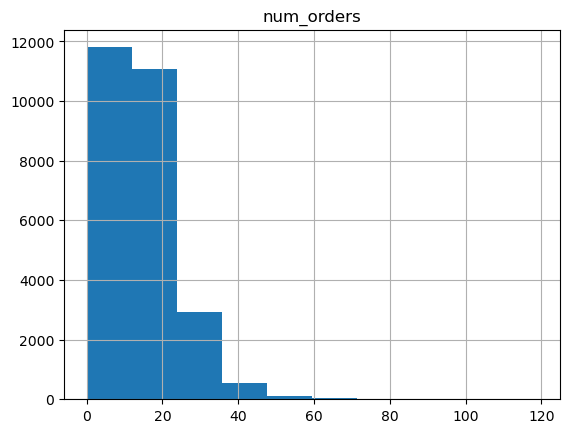

In [13]:
df.hist()
plt.show()

In [14]:
df.value_counts().sort_index()

num_orders
0             537
1             584
2             595
3             661
4             820
             ... 
94              1
95              1
98              1
99              1
119             2
Length: 81, dtype: int64

Мы видим большое количество записей с количеством заказов меньше 5, а также единичный значения с количеством заказов больше 100.

Для дальнейшего анализа ресемплируем данные по одному часу и проанализируем тренд и сезонность.

In [15]:
df = df.resample('H').sum()

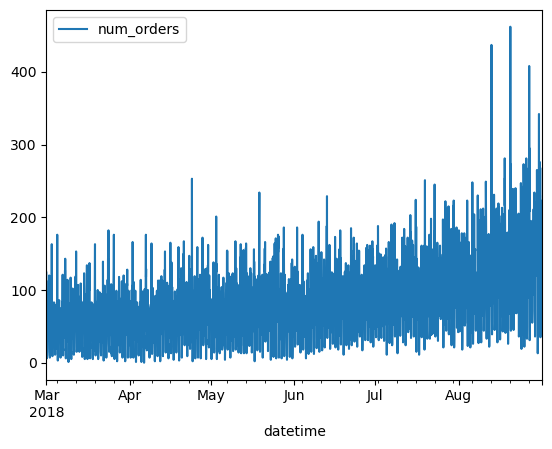

In [16]:
df.plot()
plt.show()

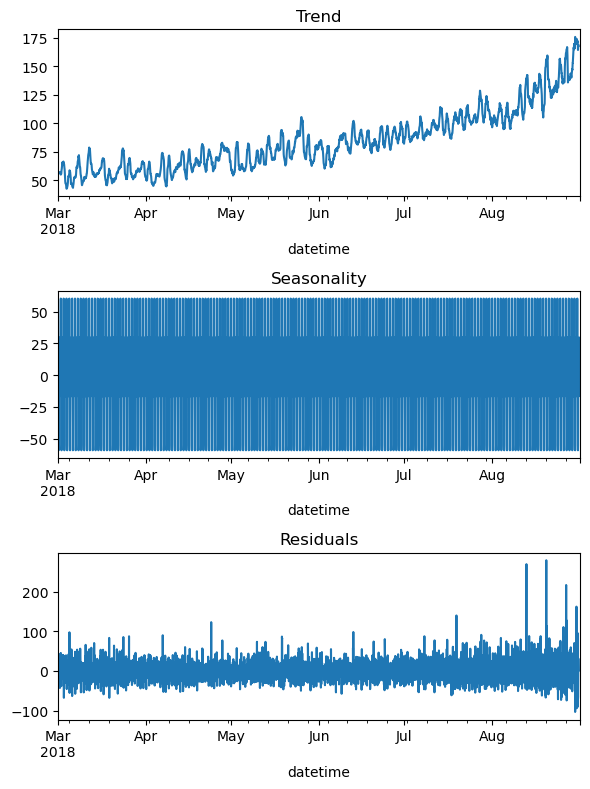

In [17]:
decomposed = seasonal_decompose(df)


plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы видим, что количество заказов имеет тенденцию к увеличению. Посмотрим более подробно на сезонность в течение недели.

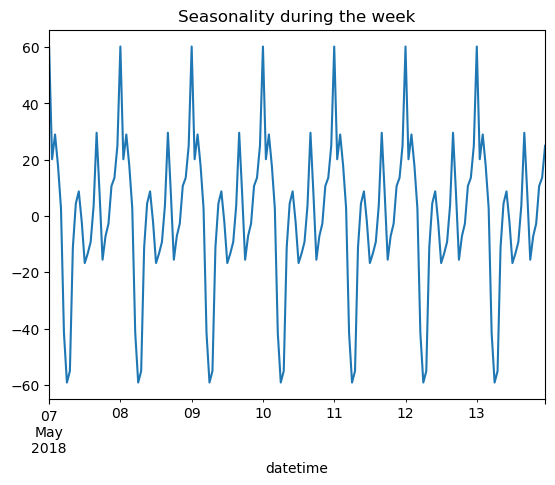

In [18]:
decomposed.seasonal['2018-05-07':'2018-05-13'].plot(ax=plt.gca())
plt.title('Seasonality during the week')
plt.show()

Мы видим, что сезонность не зависит от дня недели. Посмотрим сезонность по одному дню.

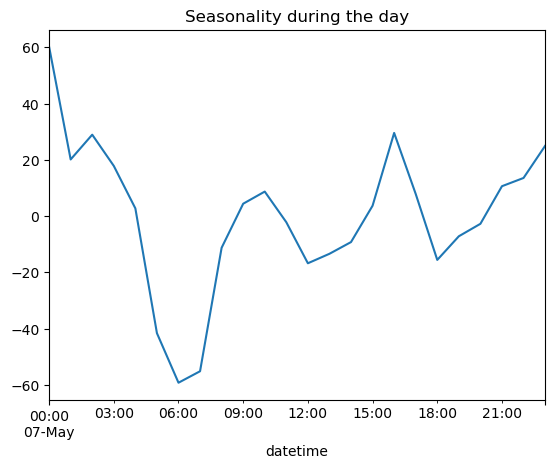

In [19]:
decomposed.seasonal['2018-05-07'].plot(ax=plt.gca())
plt.title('Seasonality during the day')
plt.show()

Из графика видно, что наибольшее число заказов приходится на время с 20 до 4 часов, а также примерно в 16 часов.

Мы открыли и проанализировали данные. Проблем в данных не обнаружено.

## Обучение моделей

Подготовим данные для обучения. Для начала добавим новые признаки на основе имеющихся данных.

In [20]:
# напишем функцию для извлечения признаков
def feature_extraction(data, rolling_window_size, num_of_lags):
    df = data.copy()
    
    # добавим день недели, месяц и час
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['hour'] = df.index.hour
    
    # добавим скользящее среднее с заданным окном
    df['rolling_avg'] = df['num_orders'].rolling(rolling_window_size).mean().shift()
    
    # добавим признаки с временными лагами

    for lag in range(1, num_of_lags + 1):
            df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
            
    return df

In [21]:
# применим функцию

df_with_features = feature_extraction(df, 3, 5)

In [22]:
df_with_features.head(10)

,num_orders,month,weekday,hour,rolling_avg,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,NaN,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,2,NaN,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,93.333333,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,3,4,74.000000,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,3,3,5,60.000000,43.0,66.0,71.0,85.0,124.0
2018-03-01 06:00:00,12,3,3,6,38.333333,6.0,43.0,66.0,71.0,85.0
2018-03-01 07:00:00,15,3,3,7,20.333333,12.0,6.0,43.0,66.0,71.0
2018-03-01 08:00:00,34,3,3,8,11.000000,15.0,12.0,6.0,43.0,66.0


In [23]:
# удалим объекты с пропусками
df_with_features = df_with_features.dropna()

In [24]:
df_with_features.head()

,num_orders,month,weekday,hour,rolling_avg,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,
2018-03-01 05:00:00,6,3,3,5,60.000000,43.0,66.0,71.0,85.0,124.0
2018-03-01 06:00:00,12,3,3,6,38.333333,6.0,43.0,66.0,71.0,85.0
2018-03-01 07:00:00,15,3,3,7,20.333333,12.0,6.0,43.0,66.0,71.0
2018-03-01 08:00:00,34,3,3,8,11.000000,15.0,12.0,6.0,43.0,66.0
2018-03-01 09:00:00,69,3,3,9,20.333333,34.0,15.0,12.0,6.0,43.0


___

Подготовим выборки.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df_with_features.drop(columns='num_orders'), 
    df_with_features['num_orders'],
    test_size=0.1, random_state=0, shuffle=False)

### Линейная регрессия

In [26]:
lr_model = LinearRegression()

rmse_lr = cross_val_score(
    lr_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(), n_jobs=-1
).mean() * -1

print('RMSE линейной регрессии на обучающей выборке:', rmse_lr)

RMSE линейной регрессии на обучающей выборке: 31.714245579387637


### Решающее дерево

In [27]:
dt_model = DecisionTreeRegressor(random_state=0)

rmse_dt = cross_val_score(
    dt_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(), n_jobs=-1
).mean() * -1

print('RMSE решающего дерева на обучающей выборке:', rmse_dt)

RMSE решающего дерева на обучающей выборке: 32.66395321174487


### LightGBM

In [31]:
gb_model = lgb.LGBMRegressor()

rmse_gb = cross_val_score(
    gb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(), n_jobs=-1
).mean() * -1

print('RMSE градиентного бустинга на обучающей выборке:', rmse_gb)

RMSE градиентного бустинга на обучающей выборке: 25.43140595599725


## Тестирование лучшей модели на тестовой выборке и вывод

Наилучший результат на обучающей выборке показала модель градиентного бустинга. Проанализируем данную модель на тестовой выборке.

In [32]:
gb_model.fit(X_train, y_train)
final_predictions = gb_model.predict(X_test)

print('RMSE модели градиентного бустинга на тестовой выборке:', 
      mean_squared_error(y_test, final_predictions) ** (1/2))

RMSE модели градиентного бустинга на тестовой выборке: 46.765225043209895


Визуализируем финальные предсказания.

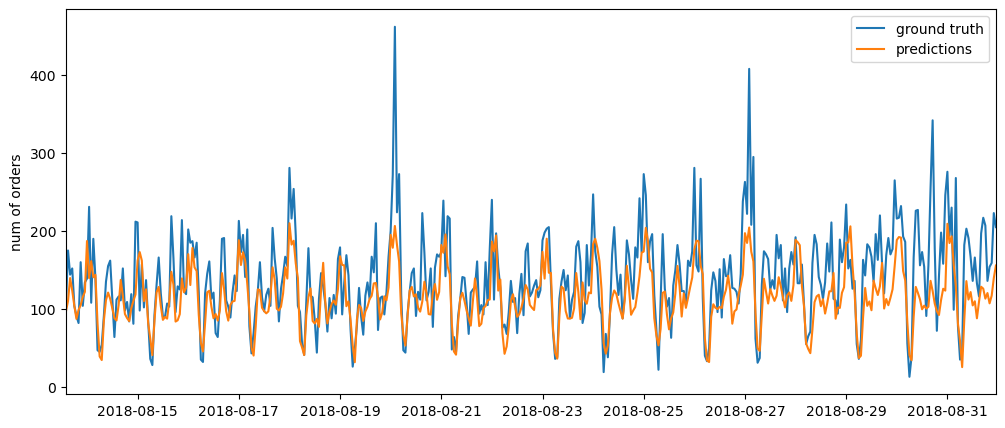

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_test.index, y_test)
ax.plot(y_test.index, final_predictions)
ax.legend(['ground truth', 'predictions'])
ax.set_ylabel('num of orders')
plt.margins(x=0)
plt.show()

Из графика видно, что модель достоточно точно предсказывает загрузку такси, за исключением пиковых моментов, которые выбиваются из общей тенденции. 


Также можно заметить, что к концу временного интервала предсказания становятся менее точными - предсказанные значения меньше фактических. Это можно объяснить тем, что модель обучалась на данных только до начала периода, охватываемого тестовой выборкой, и, как мы видели выше в анализе, количество заказов имеет положительный тренд, то есть увеличивается со временем. В реальной ситуации эту неточность можно решить последовательным дообучением модели по мере поступления новых данных.

## Вывод

Мы обработали данные о количестве заказов, ресэмплировав их по одному часу. Были проанализированы тренд и сезонность данных. Мы предобработали данные, добавив такие параметры, как месяц, день недели, час, скользящее среднее, а также данные о загрузке в предыдущие часы (с лагом).

Далее мы обучили различные модели (линейную регрессию, решающее дерево и LightGBM) для предсказания загрузки такси на основе указанных выше параметров. Проверив модели на кросс-валидации мы выяснили, что наилучшие результаты показывает модель градиентного бустинга.

Качество данной модели было проверено на тестовой выборке, показатель RMSE составил 46.8, что ниже (лучше) поставленной задачи (48). Задача проекта выполнена успешно.